In [ ]:
# !pip install mlxtend

In [1]:
import pandas as pd
import numpy as np
from matplotlib.pyplot import subplots
import statsmodels.api as sm
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from ISLP import load_data, confusion_table
from sklearn.tree import (DecisionTreeClassifier as DTC,
                          DecisionTreeRegressor as DTR,
                          plot_tree,
                          export_text)
from sklearn.metrics import (accuracy_score,
                             log_loss)
from sklearn.metrics import RocCurveDisplay
roc_curve_est = RocCurveDisplay.from_estimator 
roc_curve_pred = RocCurveDisplay.from_predictions
from sklearn.ensemble import \
     (RandomForestRegressor as RF,
      GradientBoostingRegressor as GBR,
      RandomForestClassifier as RC, 
      GradientBoostingClassifier as GBC)
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import KFold
from sklearn.model_selection import StratifiedKFold as SKF
from functools import partial
from sklearn.model_selection import \
     (cross_validate,
      ShuffleSplit)
from sklearn.decomposition import PCA
from sklearn.base import clone
from ISLP.models import sklearn_sm
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
import statsmodels.api as sm
from mlxtend.feature_selection import SequentialFeatureSelector as SFS
from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.neighbors import KNeighborsClassifier as KNN
from sklearn.metrics import make_scorer, recall_score
import warnings
warnings.filterwarnings("ignore", category=RuntimeWarning)
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
# import statsmodels as sm
import statsmodels.api as sm
from ISLP.models import (ModelSpec as MS,
                         summarize)
import math 


# Predicting Malignancy

Accurately determining whether a tumor is benign or malignant is extrememly important in cancer diagnosis and treatment planning.  
This project explores a Kaggle dataset taken from a UC Irvine study of breast cancer containing various characteristics of cell nuclei present in breast tissue, such as texture, smoothness, and symmetry to develop a machine learning model that can make this classification.

By applying data cleaning, feature selection, and predictive modeling techniques, the goal is to uncover patterns that support faster, more reliable diagnoses using data-driven insights.

In [2]:
data = pd.read_csv("Cancer_Data.csv").drop(columns={"Unnamed: 32"})
data.head()

,id,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,...,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst
0,842302,M,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,...,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
1,842517,M,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,...,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
2,84300903,M,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,...,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758
3,84348301,M,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,...,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300
4,84358402,M,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,...,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678


## Data Overview

The dataset contains 569 observations and 31 features, primarily consisting of numerical variables that describe various characteristics of cell nuclei present in digitized images of breast masses.  
These features include metrics like radius, texture, perimeter, area, and smoothness.

The target variable is categorical:  
- `"M"` indicates a malignant tumor  
- `"B"` indicates a benign tumor

In [3]:
X = data.drop(columns={"diagnosis"})
y = data["diagnosis"].map({"M": 1, "B": 0}).astype(int)
# data["diagnosis"] = data["diagnosis"].map({"M": 1, "B": 0}).astype(int)
X = X.drop(columns={"id"})

In [ ]:
data2 = data.drop(columns={"diagnosis"})
corr_matrix = data2.corr()
fig, ax = plt.subplots(figsize=(20, 20))
cax = ax.matshow(corr_matrix, cmap='coolwarm')

plt.colorbar(cax)

# Set axis labels
ax.set_xticks(range(len(data2.columns)))
ax.set_yticks(range(len(data2.columns)))

ax.set_xticklabels(data2.columns, rotation=45)
ax.set_yticklabels(data2.columns)

# Add numerical values
for (i, j), val in np.ndenumerate(corr_matrix):
    ax.text(j, i, f"{val:.2f}", ha="center", va="center", color="black")

plt.title("Correlation Matrix")
plt.show()

## Feature Selection

To reduce overfitting and improve model performance, we used cross-validation in combination with three models: Logistic Regression, K-Nearest Neighbors, and Random Forest. This is to identify the most important features for predicting tumor malignancy.

We chose forward selection as our feature selection method to reduce computation time, since the dataset includes a relatively large number of features.  
When performing forward selection, we evaluated model performance using **recall** as the scoring metric. In the context of cancer diagnosis, recall is especially important since it's better to flag a benign tumor as malignant (a false positive) than to miss a malignant one (a false negative) that could become life-threatening.

In [12]:
kf = KFold(n_splits=5, random_state=42, shuffle=True)
accuracy_scores = {}
accuracy_model = {}

# gets the correlation score between a feature and another feature
def check_correlation(feature, selected_features, threshold=0.9):
    # returns True or False, True if we should remove the feature, false we should keep the feature
    return any(abs(corr_matrix[feature][f]) > threshold for f in selected_features)


for i, (train_index, test_index) in enumerate(kf.split(X, y)):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    model = RC(n_estimators=100, random_state=42)
    model.fit(X_train, y_train)
    
    # Select top features dynamically in this fold
    importances = model.feature_importances_
    selected_features = X_train.columns[importances > 0.01]

    X_train, X_test = X_train[selected_features], X_test[selected_features]

    corr_matrix = X_train.corr()
    selected_features = []

    # checks the correlation score for each feature, removes the most correlated features
    for feature in X_train.columns:
        if not check_correlation(feature, selected_features):
            selected_features.append(feature)
        
    X_train, X_test = X_train[selected_features], X_test[selected_features]

    # standardize the data
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)  
    X_test_scaled = scaler.transform(X_test)  
    X_train = pd.DataFrame(X_train_scaled, columns=selected_features, index=X_train.index)
    X_test = pd.DataFrame(X_test_scaled, columns=selected_features, index=X_test.index)

    # train the model 
    model = RC(max_depth=3, random_state=42, max_features='sqrt')
    model.fit(X_train, y_train)

    # asses how well the selected features are
    predictions = model.predict(X_test)
    accuracy = accuracy_score(y_test, predictions)
    print("accuracy", accuracy)

    accuracy_scores[accuracy] = selected_features
    accuracy_model[accuracy] = model

best_features = accuracy_scores[max(accuracy_scores.keys())]  # Select best-performing feature set
print(best_features)
print("Max Accuracy Score", max(accuracy_scores))


accuracy 0.9473684210526315
accuracy 0.9385964912280702
accuracy 0.9298245614035088
accuracy 0.9473684210526315
accuracy 0.9380530973451328
['radius_mean', 'texture_mean', 'compactness_mean', 'concavity_mean', 'radius_se', 'compactness_worst', 'concavity_worst', 'concave points_worst', 'symmetry_worst']
Max Accuracy Score 0.9473684210526315


In [5]:
model = accuracy_model[max(accuracy_scores)]

feature_imp = pd.DataFrame(
{'importance':model.feature_importances_},
index=accuracy_scores[max(accuracy_scores)])
feature_imp.sort_values(by='importance', ascending=False)

,importance
concavity_mean,0.210520
concave points_worst,0.208540
radius_mean,0.176903
concavity_worst,0.116421
compactness_mean,0.075384
radius_se,0.061864
texture_mean,0.023018
compactness_worst,0.018028
concavity_se,0.013964
fractal_dimension_mean,0.013349


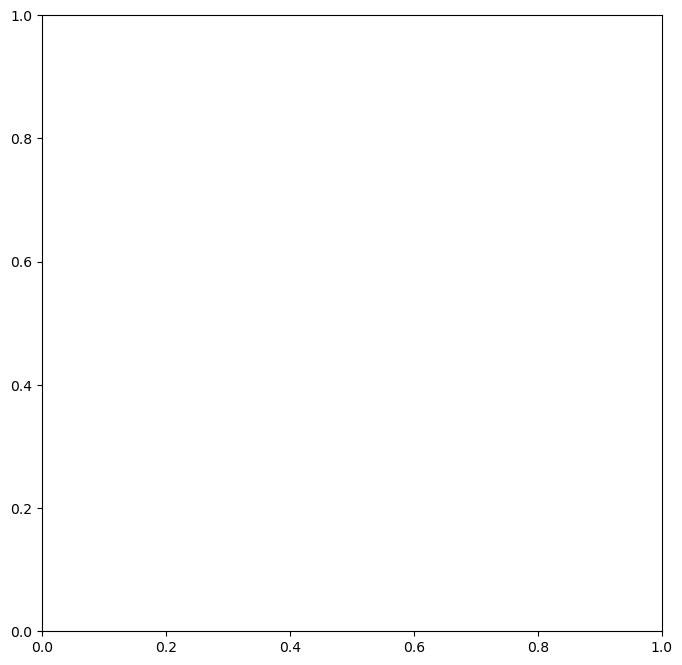

In [6]:
fig, ax = subplots(figsize=(8,8))

accuracy 0.958041958041958
Truth       0   1
Predicted        
0          91   2
1           4  46


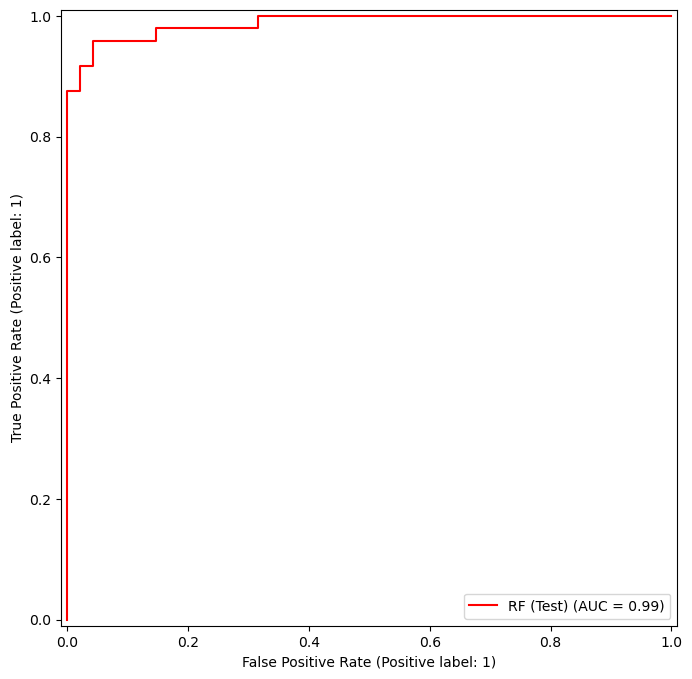

In [ ]:
# train test  splits to evaluate our model with the selected features
X_RF = X[accuracy_scores[max(accuracy_scores)]]
X_train, X_test, y_train, y_test = train_test_split(X_RF,
                                                    y,
                                                    random_state=314,
                                                    test_size=0.25,
                                                    shuffle=True) 


model = RC(max_depth=3, random_state=42, max_features='sqrt')
model.fit(X_train, y_train)

predictions = model.predict(X_test)
accuracy = accuracy_score(y_test, predictions)
print("accuracy", accuracy)
print(confusion_table(predictions, y_test))
# print(summarize(model))

RF = roc_curve_est(model,
              X_test,
              y_test,
              name='RF (Test)',
              color='r',
              ax=ax);
fig

In [ ]:
# pCA = loading, what var are apart of it 